<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/StreamTurbines/BladeDesign_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
rad2deg = 180/np.pi
deg2rad = np.pi/180

In [3]:
class TurbineOpt:

    def __init__( self, λtip, Z ):
        self.λtip = λtip
        self.Z = Z
        self.λr = np.nan

    def set_λr( self, λr ):
        self.λr = λr

    def tip_loss( self, a, ap, λr ):
        ff = -0.5 * self.Z * ( self.λtip / self.λr - 1 ) * np.sqrt( 1 + ( self.λr / (1-a) )**2 )
        rr =  2.0 / np.pi * np.arccos( np.exp( ff ) )
        # rr = 1
        return rr

    def f_objective( self, X ):
        a  = X[0]
        ap = X[1]
        k = self.tip_loss( a, ap, self.λr )
        fO = k * ap * ( 1.0 - a ) * self.λr**3
        return -fO

    def f_constraint( self, X ):
        a  = X[0]
        ap = X[1]
        fC = ( 1.0 + ap ) * ap * self.λr**2 - ( 1.0 - a ) * a
        return fC

## Glauert optimal distribution

C_P = 0.5026


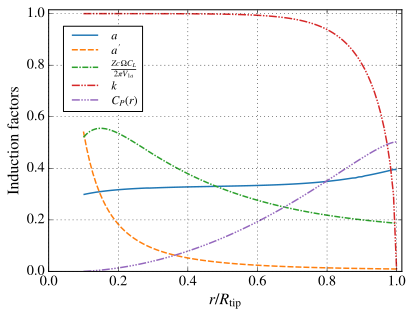

In [15]:
λtip = 5.0
TOpt = TurbineOpt( λtip, Z = 3 )

λr_vec  = []
ϕ_vec   = []
a_vec   = []
ap_vec  = []
k_vec   = []
EE_vec  = []
CPr_vec = []
CP_vec  = []

# λr_set = np.concatenate( ( np.linspace( 0.25, 2.0, 8 ),
                            #  np.linspace( 2.5, 6.0, 8 ),
                            #  np.linspace( 7, 12,6 ) ) )
λr_set = np.linspace( λtip/10.0, λtip, 100 )

# initial conditions
X0 = ( 0.33, 0.01 )

for i, λr in enumerate( λr_set ):

    TOpt.set_λr( λr )
    cons = [ { 'type': 'eq', 'fun': TOpt.f_constraint } ]
    sol = minimize( TOpt.f_objective, X0, constraints = cons )
    X0 = sol.x

    a  = X0[0]
    ap = X0[1]

    k = TOpt.tip_loss( a, ap, λr )
    ϕ = np.arctan( ( 1 - a ) / ( 1 + ap ) / λr )
    EE  = 4.0 * ap * λr**2 / np.sqrt( (1-a)**2 + (1+ap)**2 * λr**2 )
    CPr = 8 / λtip**2 * k * ap * ( 1.0 - a ) * λr**3

    λr_vec.append( λr )
    a_vec.append( a )
    ap_vec.append( ap )
    ϕ_vec.append( ϕ )
    k_vec.append( k )
    EE_vec.append( EE )
    CPr_vec.append( CPr )

    if i > 0:
        dλr = λr_vec[i] - λr_vec[i-1]
        CPm = 0.5 * ( CPr_vec[i] + CPr_vec[i-1] )
        CP  = CP_vec[i-1] + CPm * dλr
    else:
        CP = 0.0

    CP_vec.append( CP )

x_vec = np.array( λr_vec ) / λtip

mpl.plot( x_vec, a_vec,  label = r"$a$" )
mpl.plot( x_vec, ap_vec, label = r"$a'$" )
mpl.plot( x_vec, EE_vec, label = r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, k_vec,  label = r"$k$" )
mpl.plot( x_vec, CP_vec, label = r"$C_P(r)$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.ylabel( "Induction factors")
mpl.legend( loc="upper left", fontsize=12, handlelength=2.8, \
            labelspacing=.3, bbox_to_anchor=(0.025,0.96) )
mpl.xlim( [ 0, 1.015 ] )
mpl.ylim( [ 0, 1.015 ] )
mpl.grid()
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {CP_vec[-1]:.4f}" )

In [16]:
df = pd.DataFrame( { r"$\lambda_r$": λr_vec,
                     r"$a$": np.round(a_vec,decimals=5),
                     r"$a'$": np.round(ap_vec,decimals=5),
                     r"$\phi$": np.round(ϕ_vec, decimals=2)*rad2deg,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": np.round(EE_vec, decimals=5)
                    } )

# print( df.to_latex(index=False,
#                   formatters={"name": str.upper},
#                   float_format="{:.5f}".format,
# ))
df

,$\lambda_r$,$a$,$a'$,$\phi$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$"
0,0.500000,0.29831,0.54273,42.398877,0.52047
1,0.545455,0.30089,0.47827,40.680003,0.53334
2,0.590909,0.30321,0.42470,39.534088,0.54279
3,0.636364,0.30533,0.37964,38.388172,0.54929
4,0.681818,0.30744,0.34144,37.242257,0.55342
...,...,...,...,...,...
95,4.818182,0.38630,0.01011,7.448451,0.19138
96,4.863636,0.38916,0.00995,6.875494,0.19021
97,4.909091,0.39210,0.00979,6.875494,0.18905
98,4.954545,0.39522,0.00964,6.875494,0.18793


## Computing the turbine blade

C_P = 0.3729


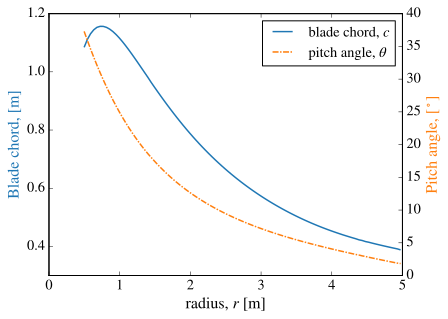

In [17]:
V1a = 2.5
Ω = 24.0 * np.pi / 30.0
Z = 3

α  = 5 * deg2rad
CL = 1.00
CD = 0.05
γ = np.arctan( CD / CL )

EE_factor = 2.0 * np.pi / Z * V1a / Ω / CL

θ_vec = []
r_vec = []
c_vec = []
CP2_vec = []

for i, ( λr, a, ap, ϕ, EE ) in enumerate( zip( λr_vec, a_vec, ap_vec, ϕ_vec, EE_vec ) ):

    θ = ϕ - α
    r = λr * V1a / Ω
    c = EE * EE_factor
    η = np.sin( ϕ - γ ) / np.sin( ϕ )

    if i > 0:
        dλr = λr_vec[i] - λr_vec[i-1]
        CPm = 0.5 * ( CPr_vec[i] + CPr_vec[i-1] )
        CP2 = CP2_vec[i-1] + η * CPm * dλr
    else:
        CP2 = 0.0

    CP2_vec.append( CP2 )

    θ_vec.append( θ )
    r_vec.append( r )
    c_vec.append( c )

ax1 = mpl.gca()
ax1.plot( r_vec, c_vec, mut.linecolors[0], label="blade chord, $c$" )
ax1.set_ylabel( "Blade chord, [m]", color=mut.linecolors[0] )
ax1.set_xlabel( r"radius, $r$ [m]")
ax2 = mpl.gca().twinx()
ax2.plot( r_vec, np.array( θ_vec ) * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( "Pitch angle, [$^\circ$]", color=mut.linecolors[1] )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

print( f"C_P = {CP2_vec[-1]:.4f}" )